Engy-4350: Nuclear Reactor Engineering Spring 2019 UMass Lowell; Prof. V. F. de Almeida **03Feb2019**

# 02c. Nuclear Data and Data Processing: Gamma Capture Cross Sections 
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

---
## Table of Contents
* [Objectives](#obj)
* [Introduction](#intro)
* [Atom sizes](#atom)
* [Nuclei relative sizes](#nuclei)
* [Radiative capture $(n,\gamma)$ cross section example](#xs1)

---

## Objectives<a id="obj"></a>
+ Demonstrate how to obtain traceable nuclear data and have them available through the notebook for analysis and problem solving.
+ Develop an intuitive sense of spatial scale of the underlying atomic world.
+ Develop an intuitive sense for the various (interaction) reactive cross sections in nuclear data in relation to the geometric cross section of the nuclei.

## Introduction<a id="intro"></a>

Refer to Notebook 02.

## Atom sizes<a id="atom"></a>
Collect the van der Walls radius of all atoms of interest. Use data directly from a periodic table package: Mendeleev python package.

In [2]:
'''Build a list of atomic van der Waals radii for all atoms of interest (<Cm)'''

# Use the Mendeleev python package (periodic table of elements)
from mendeleev import element

from collections import namedtuple
Atom = namedtuple('Atom', ['name','Z','symbol','vdw_radius'])

atoms = list()
z_max = 96  # up to Curium

for i in range(z_max):
    el = element(i+1)
    #print('%20s vdw radius [pm] = %3.1f'%(e.name,round(e.vdw_radius,1)))
    atm = Atom( name=el.name, Z=el.atomic_number, symbol=el.symbol, vdw_radius=el.vdw_radius)
    atoms.append( atm )
#van_der_waals_radii

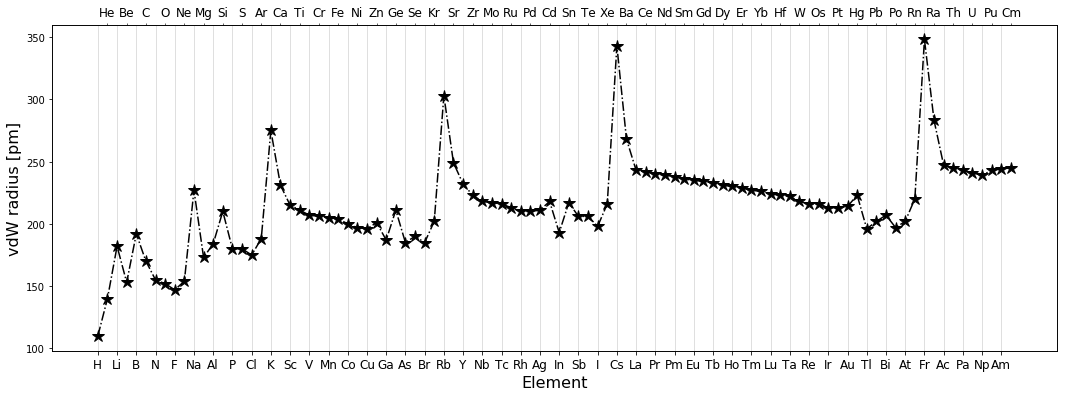

In [16]:
'''Plot the van der Walls radii for all elements of interest'''

from matplotlib import pyplot as plt # import the pyplot function of the matplotlib package
fig, ax = plt.subplots(figsize=(18,6))

ax.plot(range(len(atoms)), [atm.vdw_radius for atm in atoms], 
        '-.',color='black', marker='*',markersize=12)

plt.xticks(range(0,len(atoms),2),[atm.symbol for atm in atoms][::2],rotation=0,fontsize=12)
ax.set_ylabel('vdW radius [pm]',fontsize=16)
ax.set_xlabel('Element',fontsize=16)
ax.xaxis.grid(True,linestyle='-',which='major',color='lightgrey',alpha=0.9)

# create a twin y axis to reconfigure the top x axis
ay1 = ax.twiny()
ay1.set_xlim(ax.get_xlim())
#ay1.xaxis.tick_top()
ay1.set_xticks([])
ay1.set_xticks(range(1,len(atoms),2),[atm.symbol for atm in atoms][1::2])
ay1.set_xticklabels([atm.symbol for atm in atoms][1::2],minor=True,fontsize=12)
#ax1.spines["top"].set_position(("axes", 2))

plt.show()

## Nuclei relative sizes<a id="nuclei"></a>
Let's compute the sizes of nuclei relative to the atom they are in.

Using the [IAEA search engine](https://www-nds.iaea.org/relnsd/NdsEnsdf/QueryForm.html), 
+ expand the `More fields` of the `NUCLIDE Ground State` section, 
+ set the `Z range` to 1, 96
+ check the nuclear radius `R` button
+ click on the `Search` button
+ wait for the results window to appear (list of 3001 nuclides)
+ check the `You requested:` line to be ` 1 ≤ Z ≤96    ≤ R ≤   `
+ click on the `CSV` download button to save a table file
+ rename the file to `nuclides-z1-to-z96.csv`.

In [ ]:
'''View the raw data'''
!cat data/nuclides-z1-to-z96.csv

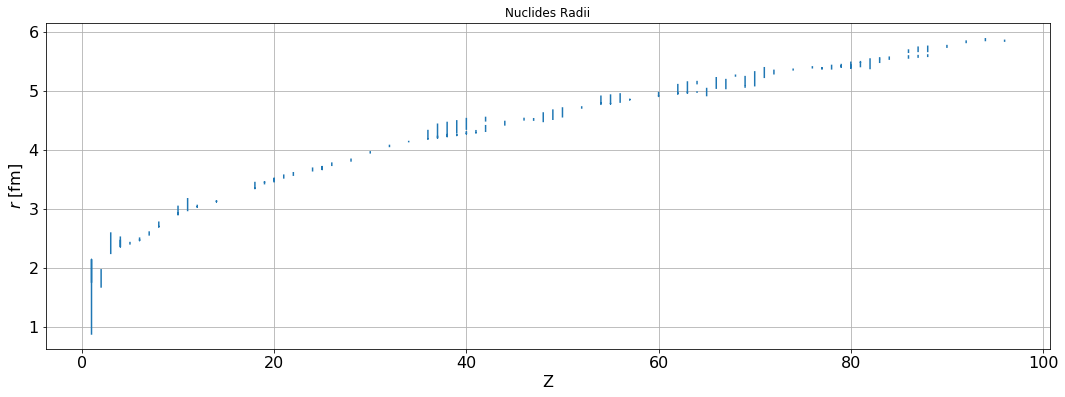

In [8]:
'''Import the data as a Pandas table'''

# Pandas: python package for tabular data analysis
import pandas as pd

# read the data into a data frame (or table)
df = pd.read_csv('data/nuclides-z1-to-z96.csv')

#print(df) # uncomment for a screen output of the data

# plot the data directly from Pandas (quick check)
ax = df.plot(x='Z', y='radius',legend=False,
             title='Nuclides Radii', fontsize=14, figsize=(18,6))
ax.set_ylabel('$r$ [fm]',fontsize=16)
ax.set_xlabel('Z',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.grid()

<span style="color:red">
**NB:** for all nuclides of interest the sizes vary by a maximum factor of 6 when the Z number vary from 1 to 96.
</span>

Let's collect the important size data for all nuclides.

In [12]:
'''Fill in a list with nuclides named tuples'''

nuclides = list()

# design a container data structure
from collections import namedtuple
Nuclide = namedtuple('Nuclide', ['name','Z','A','radius','unc'])

# fill in the list of containers
radius_misses = 0 # counter of nuclides without radius data
a_max = 0 # maximum A number with radius data present
z_max = 0 # maximum Z number with radius data present

for row in df.itertuples():
    if pd.isnull(row[4]):
        radius_misses += 1
        continue
    z = row[1]
    n = row[2]
    a = z+n
    a_max = max(a,a_max)
    z_max = max(z,z_max)
    symbol = row[3]
    nuc = Nuclide( name=row[3]+'-'+str(z+n), Z=z, A=a, radius=row[4], unc=int(row[5]) )
    nuclides.append(nuc)
    
#print(nuclides)

print('Number of nuclides with    radius data = ',len(nuclides))
print('Number of nuclides without radius data = ',radius_misses)
print('')
print('Max Z number with radius data = ',z_max)
print('Max A number with radius data = ',a_max)

Number of nuclides with    radius data =  908
Number of nuclides without radius data =  2146

Max Z number with radius data =  96
Max A number with radius data =  248


Let's calculate and plot the cross sectional area of the nuclei.

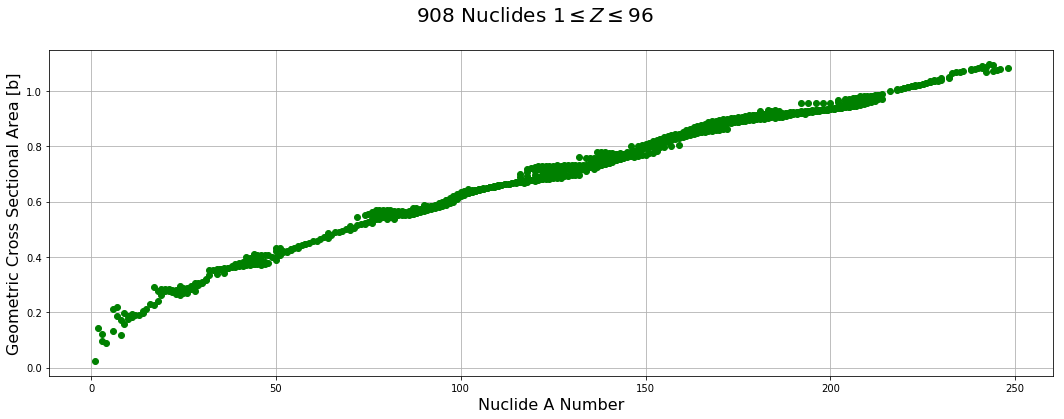

In [17]:
'''Plot the van der Walls radii for all elements of interest'''
import math

from matplotlib import pyplot as plt # import the pyplot function of the matplotlib package
fig, ax = plt.subplots(figsize=(18,6))

# plot the cross sectional area of the nuclei; 1 barn = 100 fm^2
ax.plot([nc.A for nc in nuclides], [math.pi*nc.radius**2/100 for nc in nuclides], 
        ' ',color='green', marker='.',markersize=12)

ax.set_ylabel('Geometric Cross Sectional Area [b]',fontsize=16)
ax.set_xlabel('Nuclide A Number',fontsize=16)

fig.suptitle(r'%i Nuclides $1 \leq Z \leq 96$'%(len(nuclides)),fontsize=20)
ax.grid()
plt.show()

<span style="color:red">
**NB:** for all nuclides of interest the geometric cross sectional area vary to a **maximum of ~1.1 b** when the number of nucleons vary from 1 to 248.
</span>

If an atom is the size of a classroom, say 10 m in diameter, what would the corresponding values of the nuclei be?

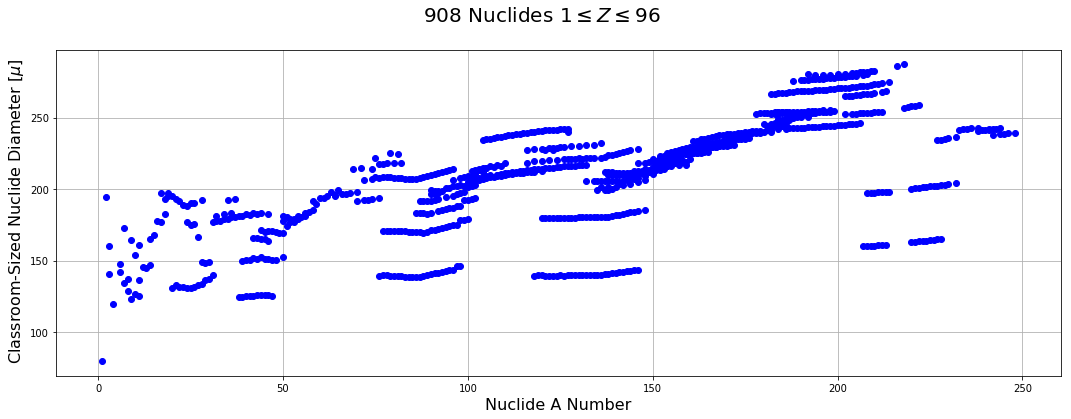

In [14]:
'''Plot the classroom size nuclei diameter'''
import math

from matplotlib import pyplot as plt # import the pyplot function of the matplotlib package
fig, ax = plt.subplots(figsize=(18,6))

# plot the classroom-sized atom nuclide diameter for a classroom of 10-m diameter
ax.plot([nc.A for nc in nuclides], [2*nc.radius*1e-15 * 5.0/atoms[nc.Z-1].vdw_radius*1e+12 * 1e+6 for nc in nuclides], 
        ' ',color='blue', marker='.',markersize=12)

ax.set_ylabel(' Classroom-Sized Nuclide Diameter [$\mu~m$]',fontsize=16)
ax.set_xlabel('Nuclide A Number',fontsize=16)

fig.suptitle(r'%i Nuclides $1 \leq Z \leq 96$'%(len(nuclides)),fontsize=20)
ax.grid()
plt.show()

<span style="color:red">
**NB:** for all nuclides of interest the classroom sizes vary between 100 and 300 micrometers.
</span>

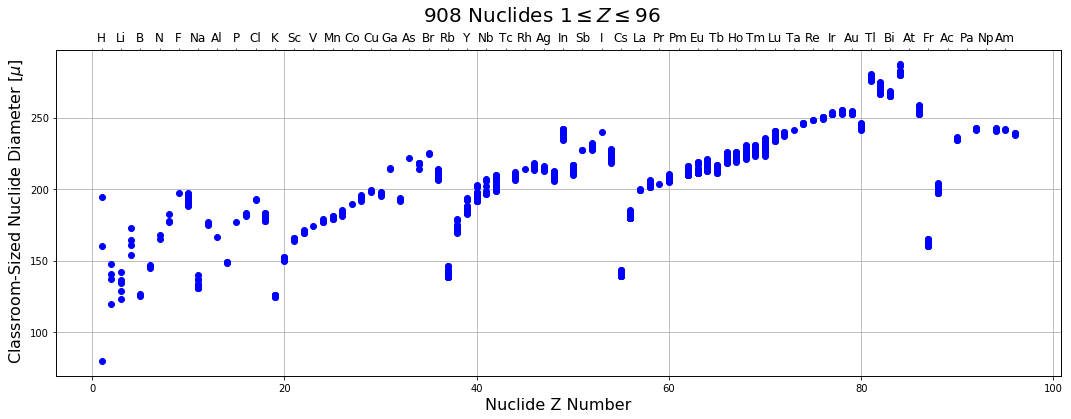

In [13]:
'''Plot the classroom size nuclei diameter'''
import math

from matplotlib import pyplot as plt # import the pyplot function of the matplotlib package
fig, ax = plt.subplots(figsize=(18,6))

ax.plot([nc.Z for nc in nuclides], [2*nc.radius*1e-15 * 5.0/atoms[nc.Z-1].vdw_radius*1e+12 * 1e+6 for nc in nuclides], 
        ' ',color='blue', marker='.',markersize=12)

#plt.xticks(range(0,len([nc.Z for nc in nuclides]),2),[nc.Z for nc in nuclides][::2],rotation=0,fontsize=12)
ax.set_ylabel(' Classroom-Sized Nuclide Diameter [$\mu~m$]',fontsize=16)
ax.set_xlabel('Nuclide Z Number',fontsize=16)

# create a twin y axis to reconfigure the top x axis
ay1 = ax.twiny()
ay1.set_xlim(ax.get_xlim())
#ay1.xaxis.tick_top()
ay1.set_xticks([])
ay1.set_xticks(range(1,len(atoms),2),[atm.symbol for atm in atoms][::2])
ay1.set_xticklabels([atm.symbol for atm in atoms][::2],minor=True,fontsize=12)
#ax1.spines["top"].set_position(("axes", 2))

fig.suptitle(r'%i Nuclides $1 \leq Z \leq 96$'%(len(nuclides)),fontsize=20)
ax.grid()
plt.show()

<span style="color:red">
**NB:** for all nuclides of interest the classroom sizes vary between 100 and 300 micrometers.
</span>

## Radiative capture $(n,\gamma)$ cross section  example<a id="xs1"></a>
This is a significant capture reaction emitting a prompt *capture* gamma ray (photon)

\begin{equation*}
^1_0\text{n} \ + \  ^{235}_{92}\text{U} \longrightarrow \ ^{236}_{92}\text{U}^* \overset{\approx 10^{-14}\,\text{s}}{\longrightarrow} \ ^{236}_{92}\text{U} \ + \ \gamma    ,
\end{equation*}

Note: 
+ a) over much of the neutron energy range in a nuclear reactor, this is the only possible parasitic reaction that influences neutron balance; neutrons of any energy can be captured with gamma emission.
+ b) often this reaction is the dominat source of radiation heating and bulk shielding in the reactor vessel.
+ c) the product nuclide is often unstable, decaying via beta emission and delayed gamma rays; the latter continues for years after reactor shutdown.

The *microscopic cross section* of this neutron interaction with the nuclide $^{235}_{92}\text{U}$ represents the probability of interaction measured in units of area; typical units are: cm$^2\times 10^{-24}$ or barn. Therefore it makes sense to compare against the geometric cross sectional area of the nuclide.

Acquiring cross section data and saving it to a file:

 + Using the [cross section data site](https://www.nndc.bnl.gov/sigma/index.jsp) click on U in the periodic table and choose $^{235}_{92}$U from the isotope list. 
 + Select the neutron capture reaction cross section $^{235}_{92}$U(n,$\gamma$) and plot the data. 
 + Choose `view evaluated data` and click on the `Text` link to view the data in a two-column arrangement (energy versus cross section). 
 + Using the browser, save data to a text file (`u-235-sigma-c.dat`). Relocate the file in a directory `data/` relative to this notebook.

In [ ]:
'''View the raw data'''
!cat data/u-235-sigma-g.dat

Importing and processing tabular data is readily done using the Pandas Python Package:
 + [Pandas documentation](https://pandas.pydata.org/).

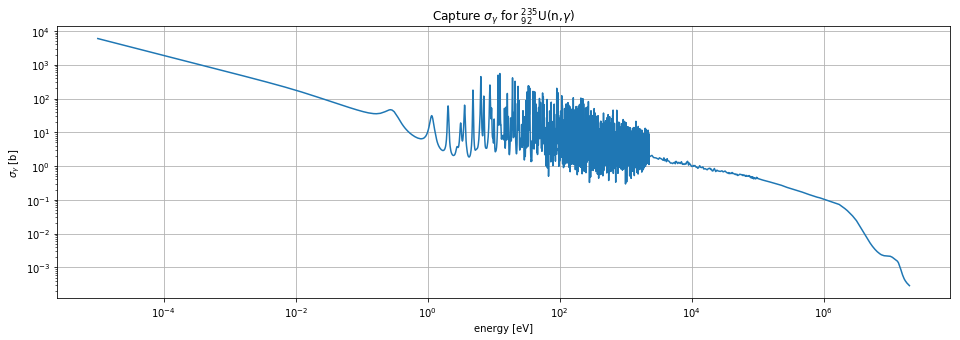

In [10]:
'''Visualize the data'''

# Pandas: python package for tabular data analysis
import pandas as pd

# read the data into a data frame (or table)
df = pd.read_csv('data/u-235-sigma-g.dat', 
                  names=['energy [eV]','sigma_g [b]'], 
                  skiprows=3)

#print(df) # uncomment for a screen output of the data

# plot the data directly from Pandas
ax = df.plot(loglog=True, x='energy [eV]', y='sigma_g [b]',legend=False,
             title='Capture $\sigma_\gamma$ for $^{235}_{92}$U(n,$\gamma$)', figsize=(16,5))
ax.set(ylabel='$\sigma_\gamma$ [b]')
ax.grid()

To obtain a *sense* of how significant this reaction is, calculate the cross sectional area of the nucleus and compare with the radiative cross section in the plot.

In [11]:
for nc in nuclides:
    if nc.name == 'U-235':
        r_u235 = nc.radius
        r_u235_unc = nc.unc
print('U-235 r [fm] = ',r_u235,r_u235_unc)

U-235 r [fm] =  5.8337 41


In [12]:
import math
area = math.pi * r_u235**2
print('nucleus geometric cross section area [b] = %5.5f'%(area/100)) # 1 barn = 100 fm^2

nucleus geometric cross section area [b] = 1.06915


From the radiative capture cross section data (plot): $\sigma_\gamma = 101.153$ b at $E=2.4\, 10^{-2}$ eV. Therefore the radiative cross section is

In [13]:
round(101.153/1.06915,1)

94.6

times greater than the nucleus geometric cross section. Note that $\sigma_\gamma\approx 1$ at $E\approx 10$ keV and this reaction is significant for a large extent of neutron energies.